In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

# Getting Started

In this notebook, we will walk you through a minimal example for candidate generation and re-reranking with the [Quaero](https://quaerofrenchmed.limsi.fr/) corpus.

## Preparation

Go to the root folder of the repository and run the following commands

`xmen dict conf/quaero.yaml`

This command creates the Quaero-specific UMLS subset as a jsonl file.
If you don't have access to UMLS metathesaurus 2014AB release, you can adapt the yaml file to point to any other release.

`xmen index conf/quaero.yaml --all`

This command creates the indices used candidate generations (both TF-IDF and SapBERT).

By default, all files are written to `~/.cache/xmen`, unless configured otherwise.

## Loading Knowledge Base and Dataset

In [2]:
from pathlib import Path
base_path = Path.home() / ".cache/xmen/quaero"

In [3]:
# Load Quaero MEDLINE subset through BigBIO dataloader
from datasets import load_dataset
dataset = load_dataset("bigbio/quaero", "quaero_medline_bigbio_kb")

Found cached dataset quaero (/home/Florian.Borchert/.cache/huggingface/datasets/bigbio___quaero/quaero_medline_bigbio_kb/1.0.0/c215a01af5fd15163e392e2f78a4f67f1fe3567d92f53b7f907c95e55dcdfe93)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Load knowledge base
from xmen import load_kb
kb = load_kb(base_path / "quaero.jsonl")

# Candidate Generation

We use the pre-computed indices to retrieve the 64 most similar concepts for each mention

In [5]:
# Generate candidates with Ensemble of TF-IDF + SapBERT
from xmen.linkers import default_ensemble
linker = default_ensemble(base_path / "index")

[08/15/23 19:13:14] INFO     Loading hierarchical faiss index                                ]8;id=894007;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=866105;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py#153\153]8;;\

                    INFO     Loading index from                                                 ]8;id=571963;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=162900;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             /home/Florian.Borchert/.cache/xmen/quaero/index/sapbert/embed_fais                    
                             s_hier.pickle                                                                         

[08/15/23 19:13:22] INFO     Loaded index of type <class 'faiss.swigfaiss.IndexHNSWFlat'> and   ]8;id=391329;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=740246;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             size 6910830                                                                          

In [6]:
candidates = linker.predict_batch(dataset, top_k=64)

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [7]:
from xmen.evaluation import *

evaluate(dataset['test'], candidates['test'])

{'strict': {'precision': 0.5802389409105586,
  'recall': 0.5804263565891473,
  'fscore': 0.5803326336186015,
  'ptp': 1797,
  'fp': 1300,
  'rtp': 1797,
  'fn': 1299,
  'n_docs_system': 833,
  'n_annos_system': 3103,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

# Semantic Group Filtering

In [8]:
from xmen.data import SemanticGroupFilter

candidates = SemanticGroupFilter(kb).transform_batch(candidates)

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [9]:
from xmen.evaluation import *

evaluate(dataset['test'], candidates['test'])

{'strict': {'precision': 0.6606276285991588,
  'recall': 0.6595607235142119,
  'fscore': 0.6600937449490868,
  'ptp': 2042,
  'fp': 1049,
  'rtp': 2042,
  'fn': 1054,
  'n_docs_system': 833,
  'n_annos_system': 3095,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

# Reranking

Finally, we train a cross-encoder to learn a better ranking from the training dataset.

Here, we consider batches of 64 candidates. The cross-encoder is trained for 3 epochs (you want to increase this for better performance). We keep the checkpoint that maximizes accuracy@1 on the validation set.

In [10]:
from xmen.reranking.cross_encoder import *
ce_dataset = CrossEncoderReranker.prepare_data(candidates, dataset, kb)

Context length: 128
Use NIL values: True


  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

In [11]:
# Train the cross-encoder on the training set and use the validation set for model selection
rr = CrossEncoderReranker()
args = CrossEncoderTrainingArgs(num_train_epochs=5)
rr.fit(args, ce_dataset["train"].dataset, ce_dataset["validation"].dataset, show_progress_bar=False)

model_name := bert-base-multilingual-cased
num_train_epochs := 5
fp16 := True
label_smoothing := False
rank_regularization := 1.0
train_layers := None
softmax_loss := True
random_seed := 42
learning_rate := 2e-05


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

2023-08-15 19:52:38 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 0:
2023-08-15 20:03:19 - Accuracy: 0.7240215924426451
2023-08-15 20:03:19 - Accuracy @ 5: 0.8562753036437247
2023-08-15 20:03:19 - Accuracy @ 64: 0.9946018893387314
2023-08-15 20:03:19 - Baseline Accuracy: 0.6686909581646424
2023-08-15 20:03:19 - Save model to ./output/cross_encoder
2023-08-15 20:21:09 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 1:
2023-08-15 20:31:50 - Accuracy: 0.7419028340080972
2023-08-15 20:31:50 - Accuracy @ 5: 0.873144399460189
2023-08-15 20:31:50 - Accuracy @ 64: 0.9946018893387314
2023-08-15 20:31:50 - Baseline Accuracy: 0.6686909581646424
2023-08-15 20:31:50 - Save model to ./output/cross_encoder
2023-08-15 20:49:38 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 2:
2023-08-15 21:00:19 - Accuracy: 0.7574224021592443
2023-08-15 21:00:19 - Accuracy @ 5: 0.8765182186234818
2023-08-15 21:00:19 - Accuracy @ 64: 0.

In [12]:
# Predict on test set
prediction = rr.rerank_batch(candidates["test"], ce_dataset["test"])

Batches:   0%|          | 0/3095 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Evaluation

We compute metrics for the predicted concepts vs. the gold-standard for different values of k

In [13]:
evaluate(dataset['test'], prediction, top_k_predictions=1)

{'strict': {'precision': 0.7628935030140657,
  'recall': 0.7357881136950905,
  'fscore': 0.7490956922065111,
  'ptp': 2278,
  'fp': 708,
  'rtp': 2278,
  'fn': 818,
  'n_docs_system': 833,
  'n_annos_system': 2986,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

In [14]:
_ = evaluate_at_k(dataset['test'], prediction)

Perf@1 0.7357881136950905
Perf@2 0.7974806201550387
Perf@4 0.8330103359173127
Perf@8 0.854328165374677
Perf@16 0.8711240310077519
Perf@32 0.8791989664082688
Perf@64 0.8833979328165374


# Error Analysis

To gain more insights into the ranking errors (and potential NER errors, which do not apply here), we use `entity_linking_error_analysis`

In [15]:
# Before re-ranking
error_analysis = entity_linking_error_analysis(dataset['test'], candidates['test'])
error_analysis.head(10)

,pred_start,pred_end,pred_text,gt_start,gt_end,gt_text,entity_match_type,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,0.0,5.0,[Etude],0.0,5.0,[Etude],tp,"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1.0,NaN,C0013621,0.692185,1009657
1,47.0,55.0,[Africain],47.0,55.0,[Africain],tp,"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,0.0,0.863724,C0027567,0.863724,1009657
2,4.0,13.0,[gangrènes],4.0,13.0,[gangrènes],tp,"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0.0,0.973051,C0017086,0.973051,1009808
3,4.0,22.0,[gangrènes gazeuses],4.0,22.0,[gangrènes gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0.0,0.935468,C0017105,0.935468,1009808
4,14.0,22.0,[gazeuses],14.0,22.0,[gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,2.0,0.808053,C0537495,0.858877,1009808
5,35.0,46.0,[tuberculose],35.0,46.0,[tuberculose],tp,"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0.0,1.0,C0041296,1.0,1019393
6,35.0,53.0,[tuberculose bovine],35.0,53.0,[tuberculose bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,0.0,1.0,C0041307,1.0,1019393
7,47.0,53.0,[bovine],47.0,53.0,[bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,3.0,1.0,C3667982,1.0,1019393
8,56.0,75.0,[Mycobacterium bovis],56.0,75.0,[Mycobacterium bovis],tp,"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,-1.0,NaN,C0041307,0.825099,1019393
9,78.0,86.0,[observés],78.0,86.0,[observés],tp,"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,1.0,0.852574,C0700325,0.852574,1019393


In [16]:
# After Re-Ranking
error_analysis = entity_linking_error_analysis(dataset['test'], prediction)
error_analysis.head(10)

,pred_start,pred_end,pred_text,gt_start,gt_end,gt_text,entity_match_type,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,0.0,5.0,[Etude],0.0,5.0,[Etude],tp,"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1.0,NaN,NIL,NaN,1009657
1,47.0,55.0,[Africain],47.0,55.0,[Africain],tp,"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,1.0,0.038171,C0085756,0.0406,1009657
2,4.0,13.0,[gangrènes],4.0,13.0,[gangrènes],tp,"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0.0,0.046875,C0017086,0.046875,1009808
3,4.0,22.0,[gangrènes gazeuses],4.0,22.0,[gangrènes gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0.0,0.054063,C0017105,0.054063,1009808
4,14.0,22.0,[gazeuses],14.0,22.0,[gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,0.0,0.077092,C0017110,0.077092,1009808
5,35.0,46.0,[tuberculose],35.0,46.0,[tuberculose],tp,"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0.0,0.048985,C0041296,0.048985,1019393
6,35.0,53.0,[tuberculose bovine],35.0,53.0,[tuberculose bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,0.0,0.056016,C0041307,0.056016,1019393
7,47.0,53.0,[bovine],47.0,53.0,[bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,0.0,0.077288,C0007452,0.077288,1019393
8,56.0,75.0,[Mycobacterium bovis],56.0,75.0,[Mycobacterium bovis],tp,"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,-1.0,NaN,C0041307,0.524893,1019393
9,78.0,86.0,[observés],78.0,86.0,[observés],tp,"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,0.0,0.059418,C0302523,0.059418,1019393


<Axes: xlabel='pred_index'>

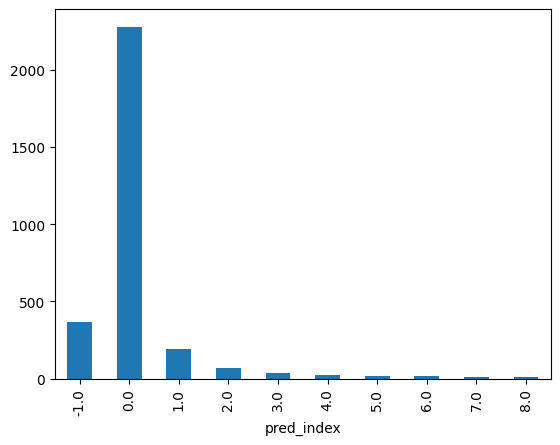

In [17]:
error_analysis.pred_index.value_counts().sort_index().iloc[0:10].plot.bar()